In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from scipy import stats
from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler as ss, MinMaxScaler as mms
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
data = pd.read_csv("BankChurners.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [4]:
data.Attrition_Flag.value_counts()

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64

In [5]:
data['Churn'] = np.where(data.Attrition_Flag == 'Attrited Customer', 1, 0)

In [6]:
data.Churn.value_counts()

0    8500
1    1627
Name: Churn, dtype: int64

In [7]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0


In [8]:
pd.set_option('display.max_columns', None)

### Categorical visualization

##### Percentage of exisiting and churned customers

The below plot is a pie chart which shows that roughly 84% of customers in our data are staying with the same firm, while 16% left.

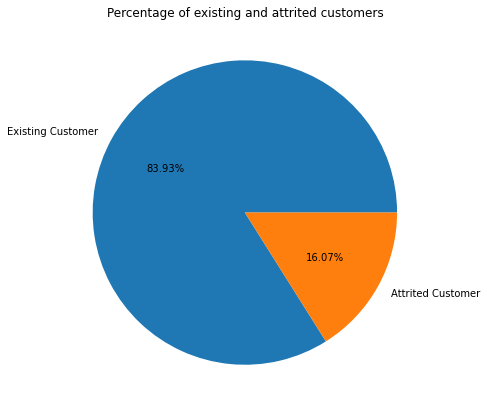

In [9]:
X = data.drop('Attrition_Flag', axis=1)
y = data['Attrition_Flag']

fig, ax = plt.subplots(figsize=(7, 7))
count = Counter(y)
ax.pie(count.values(), labels=count.keys(), autopct=lambda p:f'{p:.2f}%')
ax.set_title('Percentage of existing and attrited customers')
plt.show()

#### Level of Education

Most of the people using the bank have some form of education, with only around 1,500 not being educated

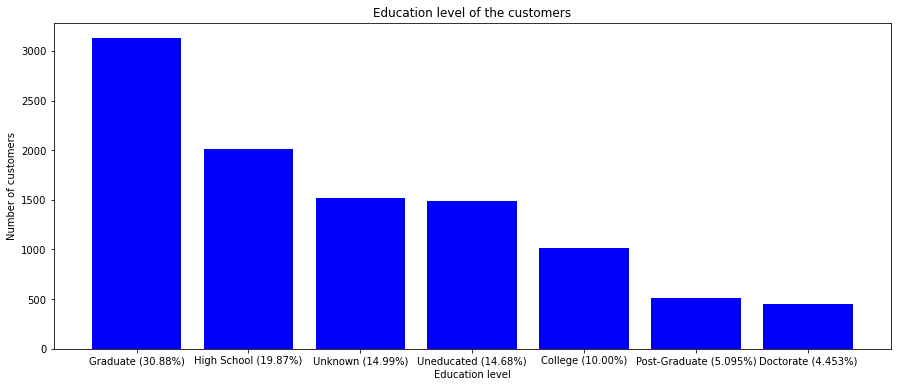

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
count = Counter(X['Education_Level'])
count = pd.Series(count).sort_values(ascending=False)
labels = []

for i in count.keys():
    labels.append(i + ' (' + str(count[i]/len(X['Education_Level'])*100)[:5] + '%)')

plt.bar(labels, count, color='blue')
plt.title('Education level of the customers')
plt.xlabel('Education level')
plt.ylabel('Number of customers')
plt.show()

##### Gender Distribution

The distribution of gender for this bank is relatively equal, with there being only around 3% more women than men.

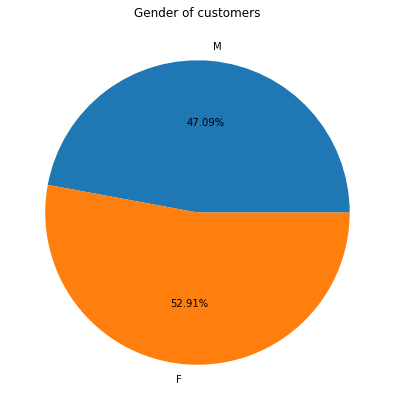

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))
count = Counter(X['Gender'])

ax.pie(count.values(), labels=count.keys(), autopct=lambda p:f'{p:.2f}%')
ax.set_title('Gender of customers')
plt.show()

#### Material Status

The marital status of the customers in our bank shows us that around half are married, roughly 40% are single, and 7% are unknown and 7% divorced.

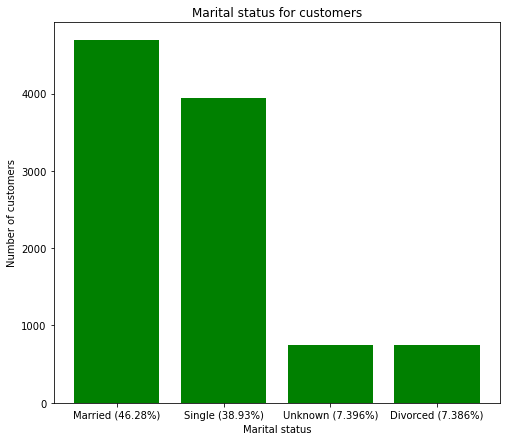

In [12]:
fig, ax = plt.subplots(figsize=(8, 7))
count = Counter(X['Marital_Status'])
labels = []

for i in count:
    labels.append(i + ' (' + str(count[i]/len(X['Marital_Status'])*100)[:5] + '%)')
    
plt.bar(labels, count.values(), color='green')
plt.title('Marital status for customers')
plt.ylabel('Number of customers')
plt.xlabel('Marital status')
plt.show()

##### Card Category
###### The vast majority (93%) of customers use blue cards, followed by Silver (5%), Gold (1%) and Platinum (0.2%).



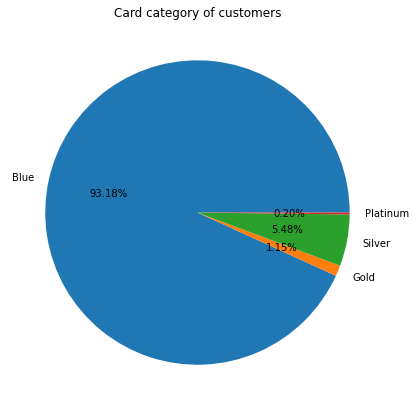

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))
count = Counter(X['Card_Category'])

ax.pie(count.values(), labels=count.keys(), autopct=lambda p:f'{p:.2f}%')
ax.set_title('Card category of customers')
plt.show()

The most common number of relationships people have had is three (22%), followed by four, five and six, which have roughly 18% each. Followed by that is 2 relationships (12%) and 1 relationship (9%).


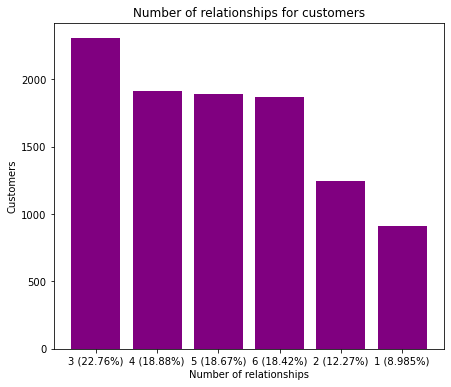

In [14]:
fig, ax = plt.subplots(figsize=(7, 6))
count = Counter(X['Total_Relationship_Count'])
count = pd.Series(count).sort_values(ascending=False)
labels = []

for i in count.keys():
    labels.append(str(i) + ' (' + str(count[i]/len(X['Total_Relationship_Count'])*100)[:5] + '%)')
    
plt.bar(labels, count, color='purple')
plt.title('Number of relationships for customers')
plt.ylabel('Customers')
plt.xlabel('Number of relationships')
plt.show()

#### Income Category

More than a third of the people make less than  40K,and the next most common categoryis 40-60K, which is almost half as frequent. After that is  80−120K(15%)  60-80K (14%), Unknown (11%) and then $120K+ (7%)

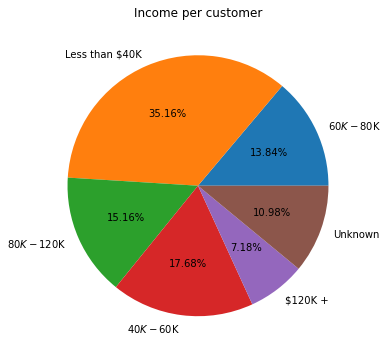

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
count = Counter(X['Income_Category'])

ax.pie(count.values(), labels=count.keys(), autopct=lambda p:f'{p:.2f}%')
ax.set_title('Income per customer')
plt.show()

## Numerical visualization

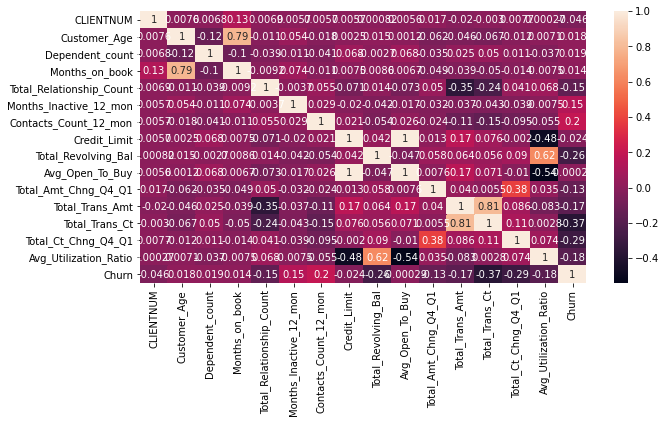

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(X.corr(), annot=True)
plt.show()

The features in our dataset have some correlation, for example, Months_on_book and Customer_age, Avg_Utilization_Ratio and Total_Revolving_Bal.

To visualise that correlation, we will use a scattergraph on the six most correlatable features: 'Total_Trans_Amt' and 'Total_Trans_Ct', 'Total_Revolving_Bal' and 'Avg_Utilization_Ratio', 'Months_on_book' and 'Customer_Age'.

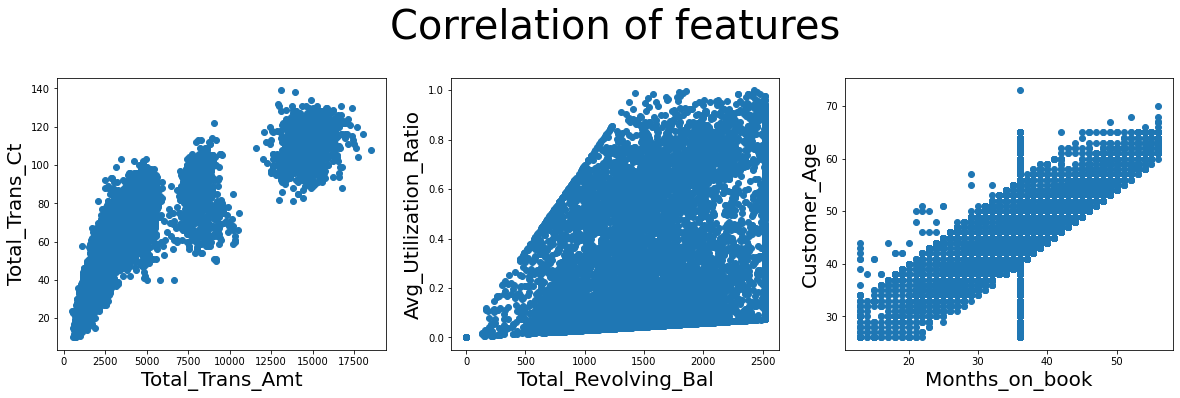

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.scatter(X['Total_Trans_Amt'], data['Total_Trans_Ct'])
ax2.scatter(X['Total_Revolving_Bal'], data['Avg_Utilization_Ratio'])
ax3.scatter(X['Months_on_book'], data['Customer_Age'])

ax1.set_xlabel('Total_Trans_Amt', fontsize=20)
ax1.set_ylabel('Total_Trans_Ct', fontsize=20)

ax2.set_xlabel('Total_Revolving_Bal', fontsize=20)
ax2.set_ylabel('Avg_Utilization_Ratio', fontsize=20)

ax3.set_xlabel('Months_on_book', fontsize=20)
ax3.set_ylabel('Customer_Age', fontsize=20)

ax2.set_title('Correlation of features', fontsize=40, pad=40)

plt.show()

Afterwards, we check the distribution of the five least evenly-distributed features and see how they change with log transform, box cox, standard scaler and min max scaler.

The graphs below show us that 'Credit_Limit' and 'Avg_Utilization_Ratio' work best without a transformation, 'Avg_Open_To_Buy' and 'Total_Amt_Chng_Q4_Q1' are best with box cox and 'Total_Trans_amt' needs the log transform on it.

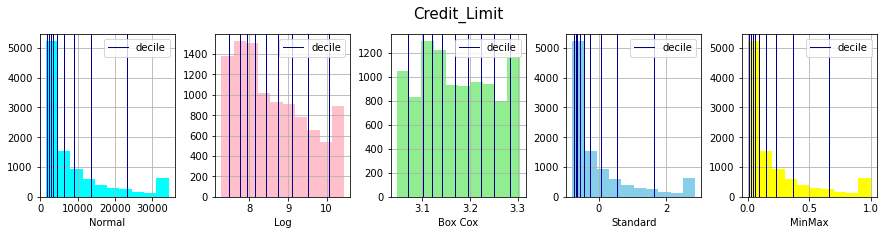

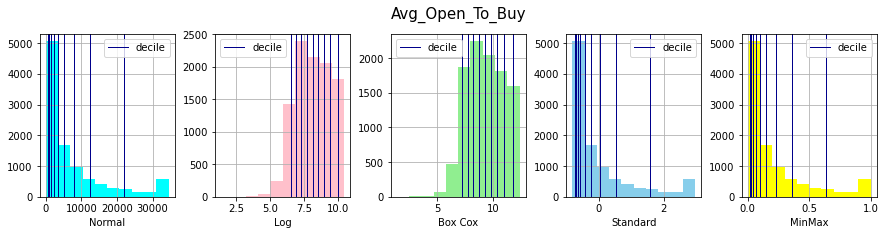

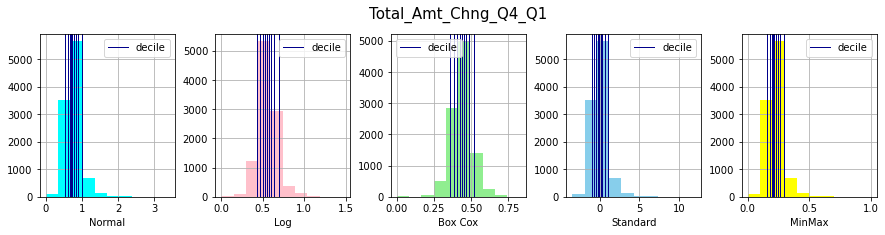

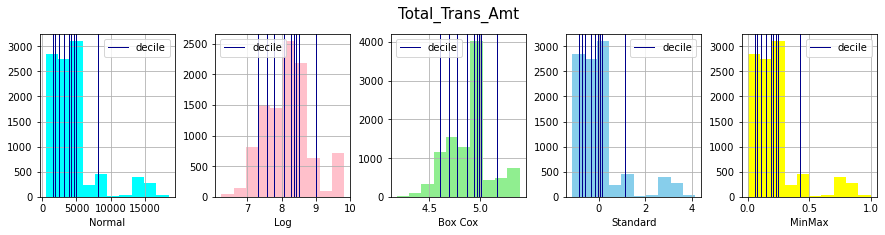

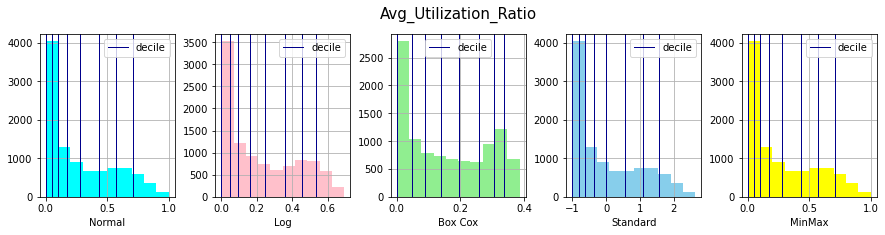

In [18]:
cols =['Credit_Limit','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Avg_Utilization_Ratio']

for col in cols:
    i = 0
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    f1 = data[col]
    f2 = (data[col]+1).transform(np.log)
    f3 = pd.DataFrame(stats.boxcox(data[col]+1)[0])
    f4 = pd.DataFrame(ss().fit_transform(np.array(data[col]).reshape(-1, 1)))
    f5 = pd.DataFrame(mms().fit_transform(np.array(data[col]).reshape(-1, 1)))
    
    for column in [[f1, 'cyan', 'Normal'], [f2, 'pink', 'Log'], [f3, 'lightgreen', 'Box Cox'], 
                   [f4, 'skyblue', 'Standard'], [f5, 'yellow', 'MinMax']]:
        feature = column[0]
        colour = column[1]
        name = column[2]
        
        feature.hist(ax=axes[i], color=colour)
        deciles = feature.quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
        
        for pos in np.array(deciles).reshape(1, -1)[0]:
            handle = axes[i].axvline(pos, color='darkblue', linewidth=1)

        axes[i].legend([handle], ['decile'])
        axes[i].set_xlabel(name)
        
        i += 1 
    
    axes[2].set_title(col, fontsize=15, pad=15)
    axes[3].set_title('')
    axes[4].set_title('')
                    
    plt.show()

plt.show()

## Predecting Customer Churn

We will firstly use a LabelEncoder to convert the 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', and 'Card_Category' columns from categorical into numerical. Afterwards, we split the X and y into train and test datasets. The train will have 80% of X and the test will have 20%.

In [19]:
data.head(2)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0


In [20]:
X = data.loc[:,'Customer_Age':'Avg_Utilization_Ratio']
y = data['Churn'] # 1: Churn 0: Existing

In [21]:
cat_cols = ['Gender','Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    
le = LabelEncoder()
y = le.fit_transform(y)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [23]:
count = Counter(y_train)
print('Distribution of target 1 & 0:', count[1], '&', count[0])

Distribution of target 1 & 0: 1318 & 6783


Next, we will create a selection of classifiers and use the best one for our final output. The predictors that will be used are XGBoost, Random Forest, K Nearest Neighbours, SGD Classifier and SVC.

In [24]:
classifiers = [[XGBClassifier(),'XGB Classifier'], [RandomForestClassifier(),'Random Forest'], 
    [KNeighborsClassifier(), 'K-Nearest Neighbours'], [SGDClassifier(),'SGD Classifier'], [SVC(),'SVC']]

To evaluate the results of our models, we will loop over them, fit them with the train sets and display the results with the score, cross_val and roc_auc metrics.

In [25]:
score_list = []
cross_val_list = []
roc_auc_list = []

for classifier in classifiers:
    model = classifier[0]
    model.fit(X_train, y_train)
    model_name = classifier[1]
    
    pred = model.predict(X_test)

    score = model.score(X_test, y_test)
    cross_val = cross_val_score(model, X_test, y_test).mean()
    roc_auc = roc_auc_score(y_test, pred)
    
    score_list.append(score)
    cross_val_list.append(cross_val)
    roc_auc_list.append(roc_auc)
    
    print(model_name, 'model score:     ' + str(round(score*100, 2)) + '%')
    print(model_name, 'cross val score: ' +str(round(cross_val*100, 2)) + '%')
    print(model_name, 'roc auc score:   ' + str(round(roc_auc*100, 2)) + '%')
    
    if model_name != classifiers[-1][1]:
        print('')

XGB Classifier model score:     97.33%
XGB Classifier cross val score: 96.1%
XGB Classifier roc auc score:   93.25%

Random Forest model score:     95.95%
Random Forest cross val score: 94.52%
Random Forest roc auc score:   89.39%

K-Nearest Neighbours model score:     89.68%
K-Nearest Neighbours cross val score: 88.2%
K-Nearest Neighbours roc auc score:   76.0%

SGD Classifier model score:     83.32%
SGD Classifier cross val score: 78.23%
SGD Classifier roc auc score:   61.36%

SVC model score:     84.75%
SVC cross val score: 84.75%
SVC roc auc score:   50.0%


Visualize the scores

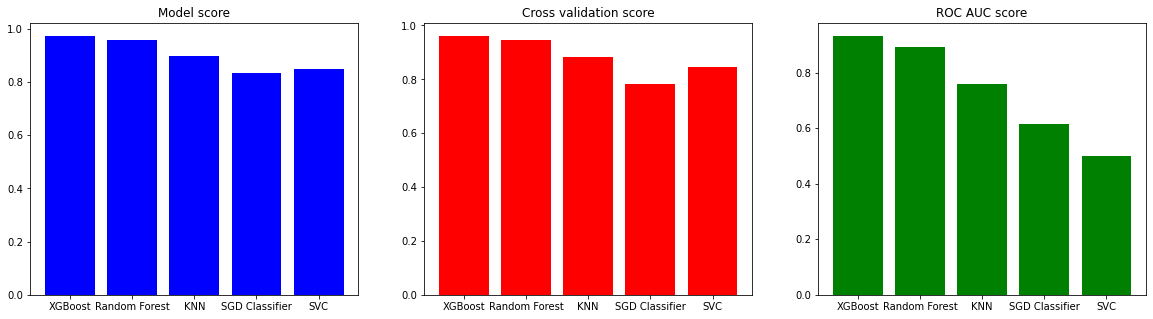

In [26]:
labels = ['XGBoost', 'Random Forest', 'KNN', 'SGD Classifier', 'SVC']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.bar(labels, score_list, color='blue')
ax2.bar(labels, cross_val_list, color='red')
ax3.bar(labels, roc_auc_list, color='green')

ax1.set_title('Model score')
ax2.set_title('Cross validation score')
ax3.set_title('ROC AUC score')

plt.show()

## XGBoost is the model we will use for our final predictions

In [27]:
model = XGBClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

score = model.score(X_test, y_test)
cross_val = cross_val_score(model, X_test, y_test).mean()
roc_auc = roc_auc_score(y_test, pred)

print('model score:     ' + str(round(score*100, 2)) + '%')
print('cross val score: ' +str(round(cross_val*100, 2)) + '%')
print('roc auc score:   ' + str(round(roc_auc*100, 2)) + '%')

model score:     97.33%
cross val score: 96.1%
roc auc score:   93.25%


### Prediciting new data

In [28]:
# Read the data
new_data = pd.read_excel("new data.xlsx")

# Pick the columns we need to include in the model based on EDA
X = new_data

cat_cols = ['Gender','Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

preds = model.predict(X)

In [66]:
preds

,Churn
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [67]:
df_preds = pd.concat([X, preds], axis=1)

In [69]:
df_preds.rename(columns={"Churn": "Customer Leaving:1, Customer staying:0"}, inplace=True)

In [70]:
df_preds

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,"Customer Leaving:1, Customer staying:0"
0,35,1,3,3,2,2,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,49,0,5,2,2,4,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,55,3.714,0.105,0
2,51,1,3,2,2,3,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,65,2.333,0.000,0
3,40,0,4,3,2,5,0,34,3,4,1,3313.0,0,796.0,1.405,1171,20,2.333,0.760,0
4,40,1,3,5,1,2,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0
5,44,1,2,2,1,1,0,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0
6,33,1,4,6,1,0,1,46,6,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066,0
7,32,1,0,3,3,2,2,27,2,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048,0
8,32,1,3,5,1,2,0,36,5,2,0,22352.0,2517,1255.0,3.355,1350,24,1.182,0.113,0
9,48,1,2,3,1,3,0,36,6,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144,0


In [71]:
y_prob = model.predict_proba(X)

In [72]:
y_prob_df = pd.DataFrame(y_prob)

In [73]:
y_prob_df.rename(columns={1: "customer_leaving_prob", 0: "customer_staying_prob"}, inplace=True)

In [74]:
y_prob_df

,customer_staying_prob,customer_leaving_prob
0,0.999966,0.000034
1,0.999999,0.000001
2,0.999989,0.000011
3,0.999781,0.000219
4,0.961064,0.038936
5,0.999782,0.000218
6,0.999985,0.000015
7,0.999848,0.000152
8,0.999990,0.000010
9,0.999989,0.000011


In [75]:
df_final_preds = pd.concat([df_preds, y_prob_df], axis=1)

In [77]:
df_final_preds

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,"Customer Leaving:1, Customer staying:0",customer_staying_prob,customer_leaving_prob
0,35,1,3,3,2,2,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,0.999966,0.000034
1,49,0,5,2,2,4,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,55,3.714,0.105,0,0.999999,0.000001
2,51,1,3,2,2,3,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,65,2.333,0.000,0,0.999989,0.000011
3,40,0,4,3,2,5,0,34,3,4,1,3313.0,0,796.0,1.405,1171,20,2.333,0.760,0,0.999781,0.000219
4,40,1,3,5,1,2,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,0.961064,0.038936
5,44,1,2,2,1,1,0,36,3,1,2,4010.0,1247,2763.0,1.376,1088,24,0.846,0.311,0,0.999782,0.000218
6,33,1,4,6,1,0,1,46,6,1,3,34516.0,2264,32252.0,1.975,1330,31,0.722,0.066,0,0.999985,0.000015
7,32,1,0,3,3,2,2,27,2,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048,0,0.999848,0.000152
8,32,1,3,5,1,2,0,36,5,2,0,22352.0,2517,1255.0,3.355,1350,24,1.182,0.113,0,0.999990,0.000010
9,48,1,2,3,1,3,0,36,6,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144,0,0.999989,0.000011
